In [2]:
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, InputLayer, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [4]:
tf.random.set_seed(
    12
)

In [5]:
tf.config.run_functions_eagerly(True)

In [6]:
data = pd.read_csv('AirQuality.csv',sep=";",parse_dates=[['Date', 'Time']],decimal=',',na_values=-200,na_filter=True)
data.drop(["Unnamed: 15","Unnamed: 16"],axis = 1,inplace = True)

data.fillna(method='ffill',inplace=True)
data.drop_duplicates(inplace=True)

data.drop(9357,inplace = True)
data['Date_Time'] = pd.to_datetime(data['Date_Time'],format="%d/%m/%Y %H.%M.%S")

In [214]:
d = pd.read_csv('AirQuality.csv',sep=";",parse_dates=[['Date', 'Time']],decimal=',',na_values=-200,na_filter=True)
d.drop(["Unnamed: 15","Unnamed: 16"],axis = 1,inplace = True)

In [217]:
d[['CO(GT)','T']].iloc[6:342].head()

,CO(GT),T
6,1.2,11.3
7,1.0,10.7
8,0.9,10.7
9,0.6,10.3
10,NaN,10.1


In [218]:
d.fillna(method='ffill',inplace=True)
d.drop_duplicates(inplace=True)

In [219]:
d[['CO(GT)','T']].iloc[6:342].head()

,CO(GT),T
6,1.2,11.3
7,1.0,10.7
8,0.9,10.7
9,0.6,10.3
10,0.6,10.1


In [7]:
d_r = data.set_index('Date_Time')

In [8]:
train_data = d_r[['CO(GT)','T']].iloc[6:6+168]
test_data = d_r[['CO(GT)','T']].iloc[6+168:6+2*168]

In [125]:
def test_model_mape(preds,actual,start=8):
    """
    A function given predictions of model and actual values returns the model Performance by the metric Average MAPE
    
    args:
    
    rerturns:
    
    
    
    """
    l_mape = []
    for i,pred in enumerate(preds):
        mape = mean_absolute_percentage_error(pred,actual.iloc[(start+i)*24+6:(start+i+1)*24+6].to_numpy())
        print(f"{i}) MAPE : {mape} ")
        l_mape.append(mape) 
    
    return np.mean(l_mape)

In [11]:
## Data processing

train_x_co = []
train_y_co = []
train_x_t = []
train_y_t = []

history = 72
horizon = 24

for i in range(len(train_data)-history):
    train_x_co_t = train_data['CO(GT)'].iloc[i:i+72].to_numpy()
    train_x_t_t = train_data['T'].iloc[i:i+72].to_numpy()
    train_y_co_t = train_data['CO(GT)'].iloc[i+72:i+72+24].to_numpy()
    if len(train_y_co_t) < 24 :
        print('[INFO] LENGTH IS LESS THAN 24')
        train_y_co_t = np.pad(train_y_co_t,(0,24-len(train_y_co_t)),'edge')
    train_y_t_t = train_data['T'].iloc[i+72:i+72+24].to_numpy()
    if len(train_y_t_t) < 24:
        train_y_t_t = np.pad(train_y_t_t,(0,24-len(train_y_t_t)),'edge')
        
    train_x_co.append(train_x_co_t)
    train_x_t.append(train_x_t_t)
    train_y_co.append(train_y_co_t)
    train_y_t.append(train_y_t_t)

[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24
[INFO] LENGTH IS LESS THAN 24


In [12]:
train_x_co = np.array(train_x_co)
train_y_co = np.array(train_y_co)
train_x_t = np.array(train_x_t)
train_y_t = np.array(train_y_t)

In [188]:
model = Sequential()
model.add(Bidirectional(LSTM(64,input_shape=(72,1),return_sequences=True)))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(tf.keras.layers.Flatten())
model.add(Dense(24))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['acc','mape'])

In [189]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30,restore_best_weights = True)

In [190]:
train_x_co.reshape(-1,72,1).shape

(96, 72, 1)

In [191]:
train_y_co.shape

(96, 24)

In [192]:
model.fit(x=train_x_co.reshape(-1,72,1),y=train_y_co, verbose=2, epochs=500,callbacks=[callback])

Epoch 1/500
3/3 - 1s - loss: 2.0361 - acc: 0.0312 - mape: 75.3818
Epoch 2/500
3/3 - 1s - loss: 1.5306 - acc: 0.0417 - mape: 94.0800
Epoch 3/500
3/3 - 1s - loss: 1.3889 - acc: 0.0417 - mape: 54.1257
Epoch 4/500
3/3 - 1s - loss: 1.2413 - acc: 0.0417 - mape: 60.3778
Epoch 5/500
3/3 - 1s - loss: 1.2519 - acc: 0.0938 - mape: 71.0688
Epoch 6/500
3/3 - 1s - loss: 1.1936 - acc: 0.0521 - mape: 55.0219
Epoch 7/500
3/3 - 2s - loss: 1.1840 - acc: 0.0208 - mape: 53.2306
Epoch 8/500
3/3 - 1s - loss: 1.1579 - acc: 0.0208 - mape: 60.4028
Epoch 9/500
3/3 - 1s - loss: 1.1361 - acc: 0.0521 - mape: 56.8526
Epoch 10/500
3/3 - 1s - loss: 1.1219 - acc: 0.0625 - mape: 48.8785
Epoch 11/500
3/3 - 1s - loss: 1.0900 - acc: 0.0312 - mape: 47.8138
Epoch 12/500
3/3 - 1s - loss: 1.0686 - acc: 0.0625 - mape: 48.7230
Epoch 13/500
3/3 - 1s - loss: 1.0302 - acc: 0.0312 - mape: 42.2363
Epoch 14/500
3/3 - 1s - loss: 1.0017 - acc: 0.0833 - mape: 36.6945
Epoch 15/500
3/3 - 1s - loss: 0.9672 - acc: 0.1354 - mape: 35.2649
Epoc

Epoch 124/500
3/3 - 1s - loss: 0.2264 - acc: 0.8333 - mape: 8.7471
Epoch 125/500
3/3 - 1s - loss: 0.2311 - acc: 0.8125 - mape: 9.0989
Epoch 126/500
3/3 - 1s - loss: 0.2289 - acc: 0.8125 - mape: 8.8399
Epoch 127/500
3/3 - 1s - loss: 0.2277 - acc: 0.8229 - mape: 8.9990
Epoch 128/500
3/3 - 1s - loss: 0.2295 - acc: 0.8229 - mape: 9.0589
Epoch 129/500
3/3 - 1s - loss: 0.2266 - acc: 0.8229 - mape: 8.8593
Epoch 130/500
3/3 - 1s - loss: 0.2268 - acc: 0.8333 - mape: 8.9672
Epoch 131/500
3/3 - 1s - loss: 0.2222 - acc: 0.8438 - mape: 8.8112
Epoch 132/500
3/3 - 1s - loss: 0.2232 - acc: 0.8125 - mape: 8.9359
Epoch 133/500
3/3 - 1s - loss: 0.2111 - acc: 0.8229 - mape: 8.4308
Epoch 134/500
3/3 - 1s - loss: 0.2131 - acc: 0.8438 - mape: 8.5068
Epoch 135/500
3/3 - 1s - loss: 0.2104 - acc: 0.8438 - mape: 8.2953
Epoch 136/500
3/3 - 1s - loss: 0.2071 - acc: 0.8333 - mape: 8.3184
Epoch 137/500
3/3 - 1s - loss: 0.2095 - acc: 0.8333 - mape: 8.4630
Epoch 138/500
3/3 - 1s - loss: 0.2045 - acc: 0.8438 - mape: 8.

Epoch 247/500
3/3 - 2s - loss: 0.0926 - acc: 0.9583 - mape: 4.4476
Epoch 248/500
3/3 - 1s - loss: 0.0959 - acc: 0.9271 - mape: 5.0154
Epoch 249/500
3/3 - 1s - loss: 0.0968 - acc: 0.9688 - mape: 4.4975
Epoch 250/500
3/3 - 1s - loss: 0.0890 - acc: 0.8958 - mape: 4.5828
Epoch 251/500
3/3 - 1s - loss: 0.0782 - acc: 0.9271 - mape: 3.9663
Epoch 252/500
3/3 - 1s - loss: 0.0767 - acc: 0.9375 - mape: 3.6624
Epoch 253/500
3/3 - 1s - loss: 0.0708 - acc: 0.9583 - mape: 3.5141
Epoch 254/500
3/3 - 1s - loss: 0.0746 - acc: 0.9375 - mape: 3.7774
Epoch 255/500
3/3 - 1s - loss: 0.0656 - acc: 0.9583 - mape: 3.4073
Epoch 256/500
3/3 - 1s - loss: 0.0702 - acc: 0.9375 - mape: 3.5844
Epoch 257/500
3/3 - 1s - loss: 0.0650 - acc: 0.9375 - mape: 3.3066
Epoch 258/500
3/3 - 1s - loss: 0.0788 - acc: 0.9479 - mape: 3.8116
Epoch 259/500
3/3 - 1s - loss: 0.0698 - acc: 0.9271 - mape: 3.4493
Epoch 260/500
3/3 - 1s - loss: 0.0721 - acc: 0.9688 - mape: 3.7262
Epoch 261/500
3/3 - 1s - loss: 0.0694 - acc: 0.9792 - mape: 3.

In [193]:
test_set = []
for i in range(4,11):
    test_set.append(d_r['CO(GT)'].iloc[i*24+6:(i+3)*24+6].to_numpy())
test_set_preds = model.predict(np.array(test_set).reshape(-1,72,1))
for i,pred in enumerate(test_set_preds):
    print(f"{i}) MAPE : {mean_absolute_percentage_error(pred,d_r['CO(GT)'].iloc[(8+i)*24+6:(9+i)*24+6].to_numpy())} ")

0) MAPE : 0.5350353537969411 
1) MAPE : 2.0797450472559276 
2) MAPE : 0.48839480934024726 
3) MAPE : 0.4558251041409959 
4) MAPE : 0.3991621551515608 
5) MAPE : 0.24568029617249007 
6) MAPE : 0.24940896946165358 


In [194]:
test_model_mape(test_set_preds,d_r['CO(GT)'])

0) MAPE : 0.5350353537969411 
1) MAPE : 2.0797450472559276 
2) MAPE : 0.48839480934024726 
3) MAPE : 0.4558251041409959 
4) MAPE : 0.3991621551515608 
5) MAPE : 0.24568029617249007 
6) MAPE : 0.24940896946165358 


0.6361788193314023

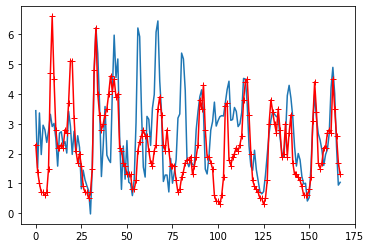

In [195]:
def show_plot(test_set_preds):
    t = list(test_set_preds[0])
    for i in range(1,len(test_set_preds)):
        t= t+list(test_set_preds[i])

    plt.plot(t)
    plt.plot(test_data['CO(GT)'].values,'r+-')

show_plot(test_set_preds)

In [62]:
def get_online_data(data,start_date):
    data_set = []
    data_set_y = []
    for i in range(24):
        data_set.append(data.iloc[6+start_date*24+i:6+(start_date+3)*24+i].to_numpy())
        data_set_y.append(data.iloc[6+(start_date+3)*24+i:6+(start_date+4)*24+i])
    print('[INFO] : ',data_set_y[0].index[0])
    return np.array(data_set),data_set_y

In [196]:
model_backup = model

In [45]:
online_x, online_y = get_online_data(d_r['CO(GT)'],4)

[INFO] :  2004-03-18 00:00:00
[INFO] :  2004-03-18 01:00:00
[INFO] :  2004-03-18 02:00:00
[INFO] :  2004-03-18 03:00:00
[INFO] :  2004-03-18 04:00:00
[INFO] :  2004-03-18 05:00:00
[INFO] :  2004-03-18 06:00:00
[INFO] :  2004-03-18 07:00:00
[INFO] :  2004-03-18 08:00:00
[INFO] :  2004-03-18 09:00:00
[INFO] :  2004-03-18 10:00:00
[INFO] :  2004-03-18 11:00:00
[INFO] :  2004-03-18 12:00:00
[INFO] :  2004-03-18 13:00:00
[INFO] :  2004-03-18 14:00:00
[INFO] :  2004-03-18 15:00:00
[INFO] :  2004-03-18 16:00:00
[INFO] :  2004-03-18 17:00:00
[INFO] :  2004-03-18 18:00:00
[INFO] :  2004-03-18 19:00:00
[INFO] :  2004-03-18 20:00:00
[INFO] :  2004-03-18 21:00:00
[INFO] :  2004-03-18 22:00:00
[INFO] :  2004-03-18 23:00:00


In [47]:
online_x, online_y = get_online_data(d_r['CO(GT)'],4+6)

[INFO] :  2004-03-24 00:00:00
[INFO] :  2004-03-24 01:00:00
[INFO] :  2004-03-24 02:00:00
[INFO] :  2004-03-24 03:00:00
[INFO] :  2004-03-24 04:00:00
[INFO] :  2004-03-24 05:00:00
[INFO] :  2004-03-24 06:00:00
[INFO] :  2004-03-24 07:00:00
[INFO] :  2004-03-24 08:00:00
[INFO] :  2004-03-24 09:00:00
[INFO] :  2004-03-24 10:00:00
[INFO] :  2004-03-24 11:00:00
[INFO] :  2004-03-24 12:00:00
[INFO] :  2004-03-24 13:00:00
[INFO] :  2004-03-24 14:00:00
[INFO] :  2004-03-24 15:00:00
[INFO] :  2004-03-24 16:00:00
[INFO] :  2004-03-24 17:00:00
[INFO] :  2004-03-24 18:00:00
[INFO] :  2004-03-24 19:00:00
[INFO] :  2004-03-24 20:00:00
[INFO] :  2004-03-24 21:00:00
[INFO] :  2004-03-24 22:00:00
[INFO] :  2004-03-24 23:00:00


In [198]:
def online_training(model):
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights = True)
    mape = []
    preds = []
    for i in range(4,10):
        online_x, online_y = get_online_data(d_r['CO(GT)'],i)
        model.fit(online_x.reshape(-1,72,1),online_y,verbose=2, epochs=5,callbacks=[callback])
        test_d = list(d_r['CO(GT)'].iloc[6+(i+1)*24:6+(i+1+3)*24].to_numpy())
        print(f"last input date in test : {d_r['CO(GT)'].iloc[6+(i+1)*24:6+(i+1+3)*24].index[-1]}")
#         print(f"{i} shape : {len(test_d)}")
        try:
            pred_ = model.predict(np.array(test_d).reshape(-1,72,1))
        except:
            print(f"{i} shape : {np.array(test_d).reshape(-1,1).shape}")
        preds.append(pred_)
        true_value = d_r['CO(GT)'].iloc[6+((i+1)+3)*24:6+((i+1)+4)*24].values
        print(f"{pred_.squeeze().shape}, {true_value.shape} ")
        e = mean_absolute_percentage_error(pred_.squeeze(),true_value)
        mape.append(e)
        print(f"{i}) mape {e}")
    return model,preds,mape # here preds go from 19 to 24
    
    

In [199]:
model_online,pds,mape = online_training(model)

[INFO] :  2004-03-18 00:00:00
Epoch 1/5
1/1 - 0s - loss: 1.8177 - acc: 0.0417 - mape: 102.4805
Epoch 2/5
1/1 - 0s - loss: 1.7529 - acc: 0.0000e+00 - mape: 99.2225
Epoch 3/5
1/1 - 0s - loss: 1.6392 - acc: 0.0000e+00 - mape: 92.4600
Epoch 4/5
1/1 - 0s - loss: 1.5006 - acc: 0.0417 - mape: 83.5502
Epoch 5/5
1/1 - 0s - loss: 1.3640 - acc: 0.0417 - mape: 73.7135
last input date in test : 2004-03-18 23:00:00
(24,), (24,) 
4) mape 0.5961913388437755
[INFO] :  2004-03-19 00:00:00
Epoch 1/5
1/1 - 0s - loss: 1.4249 - acc: 0.1667 - mape: 82.4535
Epoch 2/5
1/1 - 0s - loss: 1.3362 - acc: 0.1667 - mape: 74.9338
Epoch 3/5
1/1 - 0s - loss: 1.2181 - acc: 0.1250 - mape: 68.5782
Epoch 4/5
1/1 - 0s - loss: 1.0726 - acc: 0.1250 - mape: 63.9650
Epoch 5/5
1/1 - 1s - loss: 0.9630 - acc: 0.1250 - mape: 63.0623
last input date in test : 2004-03-19 23:00:00
(24,), (24,) 
5) mape 0.31805884576486326
[INFO] :  2004-03-20 00:00:00
Epoch 1/5
1/1 - 0s - loss: 0.9017 - acc: 0.1250 - mape: 55.4002
Epoch 2/5
1/1 - 0s - l

In [200]:
sum(mape)/len(mape)

0.5146274871473626

In [201]:
test_set_preds[1:] = np.array(pds).squeeze()
# test_set_preds

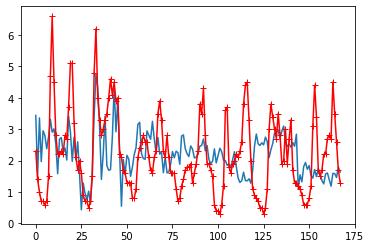

In [202]:
show_plot(test_set_preds)

In [203]:
test_model_mape(test_set_preds,d_r['CO(GT)'])

0) MAPE : 0.5350353537969411 
1) MAPE : 0.4839922431651285 
2) MAPE : 0.3732225975730094 
3) MAPE : 0.3858520314855442 
4) MAPE : 0.6248434165584342 
5) MAPE : 0.46454455297205405 
6) MAPE : 0.6456263560506814 


0.5018737930859704

In [204]:
model_online.save('lstm2_online_0_5018.h5')

In [211]:
test_model = tf.keras.('lstm2_online_0_5018.h5')

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_12/forward_lstm_12/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [213]:
for i in range(8,14):
  print(d_r['CO(GT)'].iloc[6+(i-3)*24:6+(i)*24].index[-1])

2004-03-18 23:00:00
2004-03-19 23:00:00
2004-03-20 23:00:00
2004-03-21 23:00:00
2004-03-22 23:00:00
2004-03-23 23:00:00
